# Stochastic Optimization

## The CE-Method for Combinatorial Optimization

Theory behind the algorithm is detailled in "A Tutorial on the Cross-Entropy Method" - http://web.mit.edu.

In [124]:
'''
    STOCHASTIC OPTIMIZATION
    Cross-entropy method
    
    Last reviewed: 02/12/2018
    Author: Gabriel Moreira
'''

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
plt.rcParams["animation.html"] = "jshtml"


In [133]:
'''
    Defines the problem, with the hidden y binary vector.
    Performance function to evaluate how close the vector x
    is to the hidden vector y.
    If y = x then the performance is the length of y.
'''
class optimizationProblem:
    
    def __init__(self, y):
        self.y = y # secret binary vector
        self.vector_size = len(y)
        
    def performance(self, x):
        # Performance
        s = self.vector_size - abs(np.subtract(x,self.y)).sum()
        return s

'''
    Solves the optimization problem specified with:
    - vector_size: length of the binary vector.
    - max_iter: max number of iterations allowed.
    - num_samples: number of random samples generated at each iteration.
'''
def solve(problem, max_iter, num_samples):
    '''
        Initialize a probability vector
    '''
    vector_size = problem.vector_size
    p_hat = []
    p_hat_0 = np.array([0.5]*vector_size)
    p_hat.append(p_hat_0)
    
    for t in range(max_iter):
        '''
            Generate samples X from the probability distribution
            of the previous iteration, and calculate their performances S.
        '''
        X = []
        S = [] 
        for j in range(num_samples):
            X.append(np.random.binomial(size=vector_size, n=1, p=p_hat[t]))
            S.append(problem.performance(X[j]))

        values = zip(S,X)
        sorted_samples = sorted(values, key = lambda t : t[0])
        
        '''
            Select the samples with the best performances.
            Keeps the quantile (1-rho)
        '''
        rho = 0.6
        upper_bound = int(rho*num_samples)
        del sorted_samples[:upper_bound]
        
        '''
            Calculate the new probability distribution
        '''
        cumsum = np.array([0]*vector_size)
        for j in range(len(sorted_samples)):
            cumsum = np.add(cumsum, sorted_samples[j][1])
        # New probability vector
        new_p_hat = cumsum/(num_samples-upper_bound)
        
        '''
            Verifies if the probability vector has converged.
            If so, stop and present the solution.
        '''
        if (new_p_hat == p_hat[t]).all() and sorted_samples[len(sorted_samples)-1][0] == vector_size:
            print('> Solution found!')
            print('> %d iterations.' % t)
            return p_hat
        else:
            p_hat.append(new_p_hat)
           # print('Probability vector:')
           # print(p_hat)
            
    print('> Could not find a solution.')

In [137]:
y = np.array([1,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,
              1,1,0,1,1,0,1,1,0,1,0,1,1,1,1,1,0,0,1,0,
              1,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0])

prob = optimizationProblem(y)
p = solve(problem=prob, max_iter=200, num_samples=40)

> Solution found!
> 12 iterations.


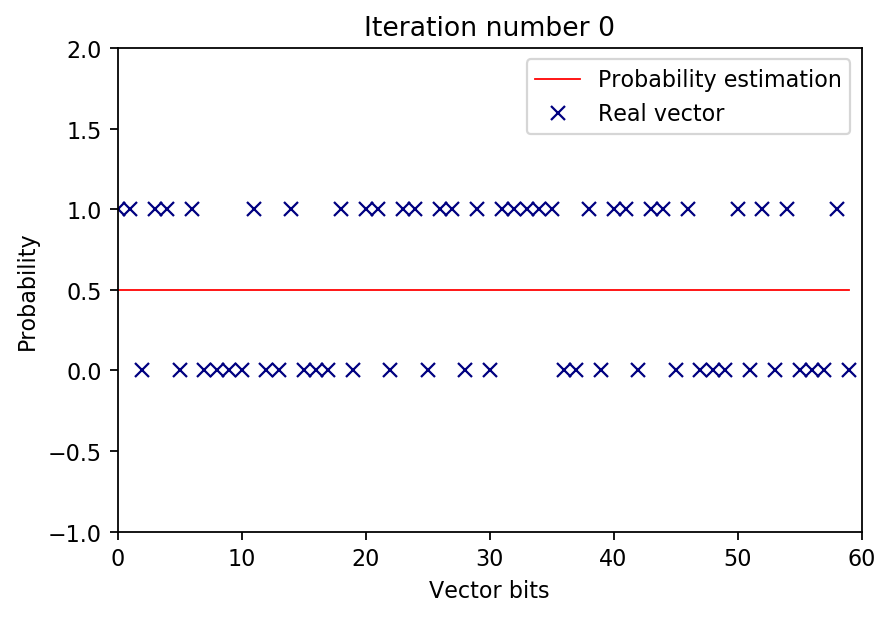

In [140]:
fig = plt.figure(dpi=160)
ax = fig.add_subplot(111, xlim=(0, len(y)), ylim=(-1, 2))
line, = ax.plot([], [], 'r-', linewidth=0.8)

def init():
    """initialize animation"""
    line.set_data([], [])
    return l

def update_line(i):
    line.set_data(np.arange(len(p[0])), p[i])
    ax.plot(np.arange(len(p[0])), y, 'x', color='navy')
    ax.set_title('Iteration number ' + str(i))
    ax.set_xlabel('Vector bits')
    ax.set_ylabel('Probability')
    ax.legend(['Probability estimation','Real vector'])
    return l,

ani = animation.FuncAnimation(fig, update_line, frames=len(p), interval=400);

In [141]:
ani